In [1]:
import pandas as pd
import numpy as np

In [2]:
def get_df_from_auction_string(auction_str: str) -> pd.DataFrame:
    rows = t_bill_auction.replace('\t', ',').replace('%', '').replace('$', '').replace('-Week', '').split('\n')
    rows  = [row for row in rows if row]

    data = [row.split(',') for row in rows]
    df = pd.DataFrame(columns=[col.strip() for col in data[0]], data=data[1:])
    df = df.astype({"Bills" : 'int64', "Issue Date":'datetime64[ns]', 'High Rate': 'float64',
                    'Investment Rate': 'float64', 'Price per 100': 'float64'})
    df.rename(columns={'Bills': 'Maturity'}, inplace=True)
    return df

In [3]:
t_bill_auction = """
Bills 	CMB 	CUSIP 	Issue Date 	High Rate 	Investment Rate 	Price per $100
4-Week	No	912797HD2	10/03/2023	5.290%	5.400%	$99.588556
8-Week	No	912797HM2	10/03/2023	5.330%	5.464%	$99.170889
13-Week	No	912796ZN2	09/28/2023	5.330%	5.493%	$98.652694
17-Week	No	912797JB4	10/03/2023	5.345%	5.532%	$98.233181
26-Week	No	912797GY7	09/28/2023	5.315%	5.553%	$97.312972
52-Week	No	912797GL5	09/07/2023	5.120%	5.417%	$94.823111
"""

In [4]:
df = get_df_from_auction_string(t_bill_auction)
df

,Maturity,CMB,CUSIP,Issue Date,High Rate,Investment Rate,Price per 100
0,4,No,912797HD2,2023-10-03,5.290,5.400,99.588556
1,8,No,912797HM2,2023-10-03,5.330,5.464,99.170889
2,13,No,912796ZN2,2023-09-28,5.330,5.493,98.652694
3,17,No,912797JB4,2023-10-03,5.345,5.532,98.233181
4,26,No,912797GY7,2023-09-28,5.315,5.553,97.312972
5,52,No,912797GL5,2023-09-07,5.120,5.417,94.823111


In [5]:
df.dtypes

Maturity                    int64
CMB                        object
CUSIP                      object
Issue Date         datetime64[ns]
High Rate                 float64
Investment Rate           float64
Price per 100             float64
dtype: object

## Calculate Price from Discount Rates
Price can be calculated using:
$$
Price = \text{Face Value} \times \bigg(1 - \frac {\text{Discount rate}}{100} \times \frac{\text {Maturity in days}}{\text {Days in a year}}\bigg)
$$

In [6]:
df['Calculated Price'] = 100 * (1 - (df['High Rate'] / 100 ) * (df['Maturity'] / 52))
df['Check Caclulated Price'] =  np.isclose(df['Price per 100'], df['Calculated Price'], atol=0.001)
df.loc[:, ['Maturity', 'Issue Date', 'High Rate', 'Investment Rate', 'Price per 100', 'Calculated Price','Check Caclulated Price']]

,Maturity,Issue Date,High Rate,Investment Rate,Price per 100,Calculated Price,Check Caclulated Price
0,4,2023-10-03,5.290,5.400,99.588556,99.593077,False
1,8,2023-10-03,5.330,5.464,99.170889,99.180000,False
2,13,2023-09-28,5.330,5.493,98.652694,98.667500,False
3,17,2023-10-03,5.345,5.532,98.233181,98.252596,False
4,26,2023-09-28,5.315,5.553,97.312972,97.342500,False
5,52,2023-09-07,5.120,5.417,94.823111,94.880000,False


## Calculate Price from Discount Rates (360 Days)
It appears that the convention is to use 360 days to calculate price:
$$
Price = 100 \times \bigg(1 - \frac {\text{Discount rate}}{100} \times \frac{\text {Maturity in days}}{360}\bigg)
$$

In [7]:
df['Calculated Price'] = 100 * (1 - (df['High Rate'] / 100 ) * (df['Maturity'] * 7 / 360))
df['Check Caclulated Price'] =  np.isclose(df['Price per 100'], df['Calculated Price'], atol=0.001)
df.loc[:, ['Maturity', 'Issue Date', 'High Rate', 'Investment Rate', 'Price per 100', 'Calculated Price','Check Caclulated Price']]

,Maturity,Issue Date,High Rate,Investment Rate,Price per 100,Calculated Price,Check Caclulated Price
0,4,2023-10-03,5.290,5.400,99.588556,99.588556,True
1,8,2023-10-03,5.330,5.464,99.170889,99.170889,True
2,13,2023-09-28,5.330,5.493,98.652694,98.652694,True
3,17,2023-10-03,5.345,5.532,98.233181,98.233181,True
4,26,2023-09-28,5.315,5.553,97.312972,97.312972,True
5,52,2023-09-07,5.120,5.417,94.823111,94.823111,True


## Calculate Investment Rate
Investment rate can be caculated as (using convention of 360 days for a year as previously):

$$
\text {Investment Rate} = \frac {\text {Face value - Buy price }}{\text {Buy price}} \times \frac {360}{\text {Maturity in days}}
$$

In [8]:
df['Calculated Investment Rate'] = ((100 - df['Price per 100']) / df['Price per 100']) * (360 / (df['Maturity'] * 7)) * 100

df['Check Investment Rate'] =  np.isclose(df['Investment Rate'], df['Calculated Investment Rate'], atol=0.001)

# re-arrange columns and remove unnecesary columns
df.loc[:, ['Maturity', 'Issue Date', 'High Rate', 'Investment Rate', 'Calculated Investment Rate', 'Check Investment Rate',
                'Price per 100']]

,Maturity,Issue Date,High Rate,Investment Rate,Calculated Investment Rate,Check Investment Rate,Price per 100
0,4,2023-10-03,5.290,5.400,5.311850,False,99.588556
1,8,2023-10-03,5.330,5.464,5.374560,False,99.170889
2,13,2023-09-28,5.330,5.493,5.402794,False,98.652694
3,17,2023-10-03,5.345,5.532,5.441134,False,98.233181
4,26,2023-09-28,5.315,5.553,5.461759,False,97.312972
5,52,2023-09-07,5.120,5.417,5.399528,False,94.823111


## Calculate Investment Rate (366 days)
It appears that the convention is to use 366 days to calculate Investment rate:

$$
\text {Investment Rate} = \frac {\text {Face value - Buy price }}{\text {Buy price}} \times \frac {366}{\text {Maturity in days}}
$$

In [9]:
df['Calculated Investment Rate'] = ((100 - df['Price per 100']) / df['Price per 100']) * (366 / (df['Maturity'] * 7)) * 100

df['Check Investment Rate'] =  np.isclose(df['Investment Rate'], df['Calculated Investment Rate'], atol=0.001)

df.loc[:, ['Maturity', 'Issue Date', 'High Rate', 'Investment Rate', 'Calculated Investment Rate', 'Check Investment Rate',
                'Price per 100']]

,Maturity,Issue Date,High Rate,Investment Rate,Calculated Investment Rate,Check Investment Rate,Price per 100
0,4,2023-10-03,5.290,5.400,5.400380,True,99.588556
1,8,2023-10-03,5.330,5.464,5.464136,True,99.170889
2,13,2023-09-28,5.330,5.493,5.492840,True,98.652694
3,17,2023-10-03,5.345,5.532,5.531819,True,98.233181
4,26,2023-09-28,5.315,5.553,5.552789,True,97.312972
5,52,2023-09-07,5.120,5.417,5.489520,False,94.823111


## Periodicity
For any bond's maturity, it is the number of such maturity periods in a year. Equating the ratio of Future Value and Present Value for different periodicities, m and n:

$$
\Bigg( 1 + \frac{APR_n}{n}\Bigg) ^n = \Bigg( 1 + \frac{APR_m}{m}\Bigg) ^m
$$

$$ 
1 + \frac{APR_n}{n} = \Bigg( \bigg( 1 + \frac{APR_m}{m}\bigg) ^m \Bigg)^\frac{1}{n}
$$

$$
\frac{APR_n}{n} = \Bigg( \bigg( 1 + \frac{APR_m}{m}\bigg) ^m \Bigg)^\frac{1}{n} - 1
$$

$$
APR_n = \Bigg( \bigg( \Big( 1 + \frac{APR_m}{m}\Big) ^m \bigg)^\frac{1}{n} - 1 \Bigg) \times n
$$

It appears that US Treasuries reports Interest Rates, for maturity > 26 weeks, with Periodicity of 2 (to be consistent with that of Notes and Bonds)

In [10]:
import math
def change_periodicity(*, rate: float, old: int, new: int) -> float:
    return (math.pow(math.pow((1 + rate / old), old), 1 / new) - 1) * new


In [11]:
change_periodicity(rate=df.at[5, 'Calculated Investment Rate']/100, old=1, new=2)*100

5.416182216769583

In [12]:
# fixing the Calculated Investment Rate only for 52 week maturity
df.at[5, 'Calculated Investment Rate'] = change_periodicity(rate=df.at[5, 'Calculated Investment Rate']/100, old=1, new=2)*100
df['Check Investment Rate'] =  np.isclose(df['Investment Rate'], df['Calculated Investment Rate'], atol=0.001)
df.loc[:, ['Maturity', 'Issue Date', 'High Rate', 'Investment Rate', 'Calculated Investment Rate', 'Check Investment Rate',
                'Price per 100']]

,Maturity,Issue Date,High Rate,Investment Rate,Calculated Investment Rate,Check Investment Rate,Price per 100
0,4,2023-10-03,5.290,5.400,5.400380,True,99.588556
1,8,2023-10-03,5.330,5.464,5.464136,True,99.170889
2,13,2023-09-28,5.330,5.493,5.492840,True,98.652694
3,17,2023-10-03,5.345,5.532,5.531819,True,98.233181
4,26,2023-09-28,5.315,5.553,5.552789,True,97.312972
5,52,2023-09-07,5.120,5.417,5.416182,True,94.823111


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

## Impact of Periodicity on Yield Curve
* As the periodicity impacts the interest rate, it is an important factor to consider while comparing interest rates
* 4 Week bond has periodicity of 13, 26 week bond has periodicity of 2 -> it is unfair to compare these interest rates values with different periodicities
* Better to change the periodicity to the same value and then compare

In [25]:
new_periodicity=2
# this is based on maturity, no special treatment for 52 weeks TBills
df['Calculated Investment Rate'] = ((100 - df['Price per 100']) / df['Price per 100']) * (366 / (df['Maturity'] * 7)) * 100

df[f'Investment Rate with Periodicity={new_periodicity}'] = df.apply(
    lambda row: change_periodicity(rate=row['Calculated Investment Rate']/100, old=int(52/row['Maturity']),
                                   new=new_periodicity)*100, axis=1
)

df.loc[:, ['Maturity', 'Issue Date', 'High Rate', 'Investment Rate', 'Calculated Investment Rate',
           f'Investment Rate with Periodicity={new_periodicity}', 'Price per 100', ]]

,Maturity,Issue Date,High Rate,Investment Rate,Calculated Investment Rate,Investment Rate with Periodicity=2,Price per 100
0,4,2023-10-03,5.290,5.400,5.400380,5.462460,99.588556
1,8,2023-10-03,5.330,5.464,5.464136,5.514049,99.170889
2,13,2023-09-28,5.330,5.493,5.492840,5.530555,98.652694
3,17,2023-10-03,5.345,5.532,5.531819,5.557242,98.233181
4,26,2023-09-28,5.315,5.553,5.552789,5.552789,97.312972
5,52,2023-09-07,5.120,5.417,5.489520,5.416182,94.823111


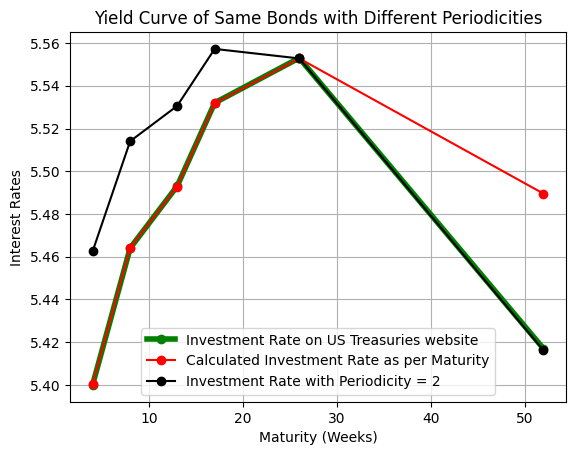

In [31]:
plt.plot(df['Maturity'], df['Investment Rate'], 'go-', label='Investment Rate on US Treasuries website', linewidth='4')
plt.plot(df['Maturity'], df['Calculated Investment Rate'], 'ro-', label='Calculated Investment Rate as per Maturity')
plt.plot(df['Maturity'], df[f'Investment Rate with Periodicity={new_periodicity}'], 'ko-',label=f'Investment Rate with Periodicity = {new_periodicity}')
plt.legend()
plt.title('Yield Curve of Same Bonds with Different Periodicities')
plt.xlabel('Maturity (Weeks)')
plt.ylabel('Interest Rates')
plt.grid()